In [1]:
import math
import time
import configparser

import numpy as np
import sklearn.linear_model
import sklearn.metrics
from matplotlib import pyplot as plt

from solml import load, cnn
import split
import get_info

%matplotlib inline

Using TensorFlow backend.


In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
models_filename = config['main']['models']

In [3]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.get_sets()

In [4]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [5]:
class_weight=None # or 'balanced'

## CNN

In [6]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, class_weight=class_weight)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.718867 seconds.
LR took 0.931053 seconds.
LR took 1.207392 seconds.
LR took 1.555092 seconds.
LR took 2.992789 seconds.
LR took 6.489259 seconds.
LR took 9.260968 seconds.
LR took 19.718962 seconds.
LR took 30.208650 seconds.
LR took 40.352445 seconds.
LR took 40.469589 seconds.
LR took 40.241684 seconds.
LR took 43.433421 seconds.
LR took 43.057628 seconds.
LR took 44.417286 seconds.
LR took 42.705153 seconds.
LR took 42.745559 seconds.
LR took 41.650874 seconds.
LR took 41.826944 seconds.
LR took 43.117941 seconds.


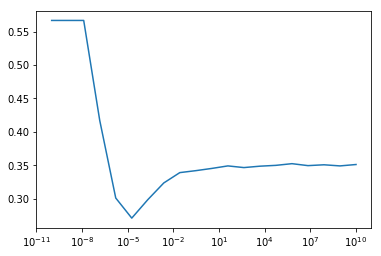

In [7]:
plt.plot(C_list, errors)
plt.xscale('log')

In [8]:
#i_opt = np.argmin(errors)
C_opt = 0.000018#C_list[i_opt]
print('optimal C : %f'%C_opt)
model_cnn = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt, class_weight=class_weight)
t = time.time()
model_cnn.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model_cnn.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000018
LR took 6.644945 seconds.


In [9]:
err

0.25166666666666665

In [10]:
cnn_proba_val = model_cnn.predict_proba(cnn_val)[:,:-1]
cnn_proba_test = model_cnn.predict_proba(cnn_test)[:,:-1]

## LR

In [14]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)
train_reduc = train_reduc.reshape((train_reduc.shape[0], 36))
val_reduc = val_reduc.reshape((val_reduc.shape[0], 36))
test_reduc = test_reduc.reshape((test_reduc.shape[0], 36))

In [15]:
model_lr = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_lr.fit(train_reduc, train_labels)
predictions = model_lr.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.43137254901960786

In [16]:
reduc_proba_val = model_lr.predict_proba(val_reduc)[:,:-1]
reduc_proba_test = model_lr.predict_proba(test_reduc)[:,:-1]

In [17]:
val_mix = np.concatenate([cnn_proba_val, reduc_proba_val], axis=1)
test_mix = np.concatenate([cnn_proba_test, reduc_proba_test], axis=1)

In [18]:
model_ensemble = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_ensemble.fit(val_mix, val_labels)
predictions = model_ensemble.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.24708333333333332

In [19]:
probas = model_ensemble.predict_proba(test_mix)

## Confusion matrix

In [20]:
sklearn.metrics.confusion_matrix(test_labels, predictions)

array([[932,  14,  16,  78],
       [ 39, 399,  12,  81],
       [ 33,  29, 160,  40],
       [150,  77,  24, 316]])

## Confidence

In [21]:
confidence = np.max(probas, axis=1)

(array([  1.,   0.,   2.,   0.,   2.,   2.,   5.,   3.,   2.,   3.,   5.,
          3.,   5.,   8.,  11.,   9.,   9.,  11.,  11.,   7.,  16.,   9.,
         23.,  19.,  12.,  18.,  16.,  26.,  24.,  28.,  17.,  22.,  21.,
         19.,  22.,  18.,  23.,  26.,  24.,  20.,  10.,  22.,  19.,  15.,
         21.,  19.,  18.,  18.,  16.,  22.,  20.,  21.,  10.,  18.,  19.,
         19.,  19.,  24.,  16.,  22.,  14.,  18.,  21.,  19.,  19.,  27.,
         25.,  22.,  35.,  30.,  33.,  27.,  23.,  30.,  33.,  42.,  28.,
         46.,  24.,  34.,  31.,  33.,  35.,  39.,  37.,  49.,  49.,  41.,
         45.,  51.,  64.,  62.,  88.,  55.,  65.,  57.,  67.,  52.,  31.,
         29.]),
 array([ 0.29049477,  0.29713296,  0.30377116,  0.31040935,  0.31704755,
         0.32368574,  0.33032394,  0.33696213,  0.34360033,  0.35023852,
         0.35687672,  0.36351491,  0.37015311,  0.3767913 ,  0.3834295 ,
         0.39006769,  0.39670589,  0.40334408,  0.40998228,  0.41662048,
         0.42325867,  0.42

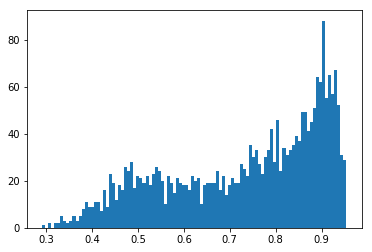

In [22]:
plt.hist(confidence, bins=100)

In [23]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N)

/home/michel/.virtualenvs/solar/lib/python3.4/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


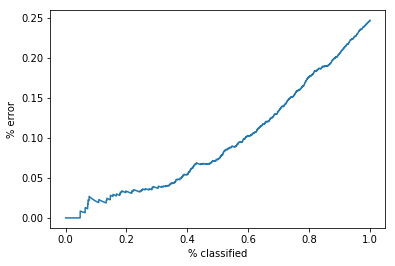

In [24]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [25]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

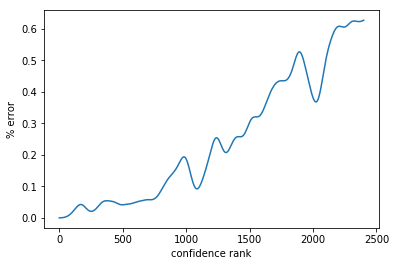

In [26]:
sigma = 40.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')

## Save model

In [27]:
import pickle
pickle.dump((model_cnn, model_lr, model_ensemble), open(models_filename, 'wb'))